In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/Questions.csv
../data/Answers.csv
../data/Tags.csv


In [ ]:
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
import torch
from string import punctuation as pnc
from collections import Counter
from scipy import spatial
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pylab as pl
pd.set_option('display.max_colwidth', -1)

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  app.launch_new_instance()


### Download english stopworld 

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Download dataset "Questions"

In [ ]:
questions = pd.read_csv("../data/Questions.csv", encoding = "ISO-8859-1")
print(len(questions))
display(questions.head(5))

607282


,Id,OwnerUserId,CreationDate,Score,Title,Body
0,469,147.0,2008-08-02T15:11:16Z,21,How can I find the full path to a font from its display name on a Mac?,"<p>I am using the Photoshop's javascript API to find the fonts in a given PSD.</p>\n\n<p>Given a font name returned by the API, I want to find the actual physical font file that that font name corresponds to on the disc.</p>\n\n<p>This is all happening in a python program running on OSX so I guess I'm looking for one of:</p>\n\n<ul>\n<li>Some Photoshop javascript</li>\n<li>A Python function</li>\n<li>An OSX API that I can call from python</li>\n</ul>\n"
1,502,147.0,2008-08-02T17:01:58Z,27,Get a preview JPEG of a PDF on Windows?,"<p>I have a cross-platform (Python) application which needs to generate a JPEG preview of the first page of a PDF.</p>\n\n<p>On the Mac I am spawning <a href=""http://developer.apple.com/documentation/Darwin/Reference/ManPages/man1/sips.1.html"">sips</a>. Is there something similarly simple I can do on Windows?</p>\n"
2,535,154.0,2008-08-02T18:43:54Z,40,Continuous Integration System for a Python Codebase,"<p>I'm starting work on a hobby project with a python codebase and would like to set up some form of continuous integration (i.e. running a battery of test-cases each time a check-in is made and sending nag e-mails to responsible persons when the tests fail) similar to CruiseControl or TeamCity.</p>\n\n<p>I realize I could do this with hooks in most VCSes, but that requires that the tests run on the same machine as the version control server, which isn't as elegant as I would like. Does anyone have any suggestions for a small, user-friendly, open-source continuous integration system suitable for a Python codebase?</p>\n"
3,594,116.0,2008-08-03T01:15:08Z,25,cx_Oracle: How do I iterate over a result set?,<p>There are several ways to iterate over a result set. What are the tradeoff of each?</p>\n
4,683,199.0,2008-08-03T13:19:16Z,28,Using 'in' to match an attribute of Python objects in an array,"<p>I don't remember whether I was dreaming or not but I seem to recall there being a function which allowed something like,</p>\r\n\r\n<pre><code>foo in iter_attr(array of python objects, attribute name)</code></pre>\r\n\r\n<p>I've looked over the docs but this kind of thing doesn't fall under any obvious listed headers</p>"


In [ ]:
print("Number of unique Questions : ", questions['Id'].nunique())

Number of unique Questions :  607282


In [ ]:
questions['qLen'] = questions['Title'].apply(lambda x : len(x.split(" ")))
questions['qBodyLen'] = questions['Body'].apply(lambda x : len(x.split(" ")))

Number of words in Title and Body

Text(0.5, 1.0, 'No. of words in Title')

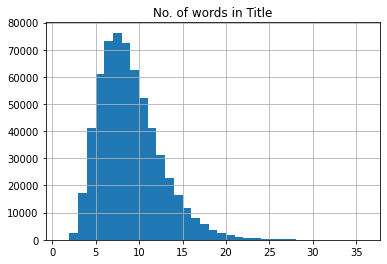

In [ ]:
questions['qLen'].hist(bins=35)
plt.title("No. of words in Title")

Text(0.5, 1.0, 'No. of words in Body')

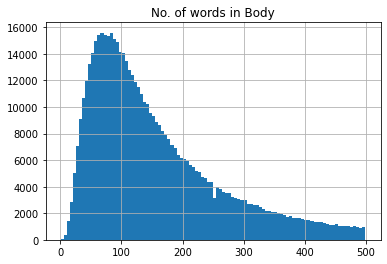

In [ ]:
questions[questions['qBodyLen']<500]['qBodyLen'].hist(bins=100)
plt.title("No. of words in Body")

## Word Cloud

In [ ]:
def getWordCloud(df,col):
  comment_words = '' 
  stopwords = set(STOPWORDS) 
    
  for val in tqdm(df[col]): 
        
      val = str(val) 
      tokens = val.split() 
        
      for i in range(len(tokens)): 
          tokens[i] = tokens[i].lower() 
        
      comment_words += " ".join(tokens)+" "
    
  wordcloud = WordCloud(width = 800, height = 800, 
                  background_color ='white', 
                  stopwords = stopwords, 
                  min_font_size = 10).generate(comment_words) 
    
                       
  plt.figure(figsize = (5, 5), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off")
  plt.tight_layout(pad = 0) 
    
  plt.show()

  0%|          | 0/607282 [00:00<?, ?it/s]

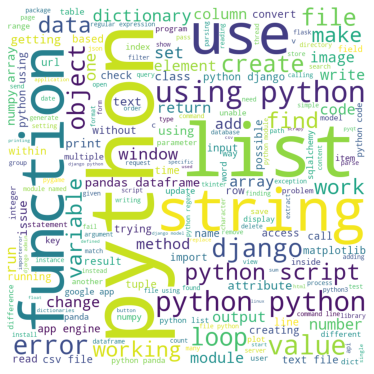

In [ ]:
getWordCloud(questions,'Title')

## Pre-Processing

Removal of Stop Words, non alphanumeric charcters, and lower case all the charcters

In [ ]:
stop = stopwords.words('english')
def preprocess(df, col):
  df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in x.split(" ") if word not in stop]))
  df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
  df['preprocessed'+col] = df['preprocessed'+col].str.lower()
  return df

In [ ]:
questions = preprocess(questions, 'Title')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


### Tags

In [ ]:
tags = pd.read_csv("../data/Tags.csv", encoding = "ISO-8859-1")
print(len(tags))
display(tags.head(5))

1885078


,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [ ]:
print("Number of unique Tags : ", tags['Tag'].nunique())

Number of unique Tags :  16895


20 Most frequent Tags Except Python which is obviously the most frequent

<AxesSubplot:>

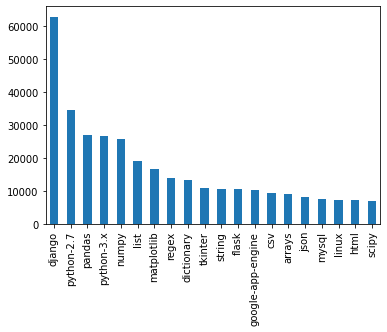

In [ ]:
fig, ax = plt.subplots()
tags[tags['Tag']!='python']['Tag'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

Encoding the Processed Question Title and Embedding it using GPT2 Tokenizer

In [ ]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

In [ ]:
preprocessedTitle = questions['preprocessedTitle'].values
QID = questions['Id'].values
print(len(preprocessedTitle), len(QID))

607282 607282


Using tokenizer.batch_encode_plus to encode all the titles in 1 go. Instead of tokenizer.batch_encode_plus, tokenizer.encode can be used to encode 1 instance at a time

In [ ]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

607282


Loading the embedding from GPT2 Model. Each token in the embedding matrix is 768 length vector and the embedding has 50257 unique tokens

In [ ]:
embeddigs = model.transformer.wte
print("Shape of embedding matrix : ",embeddigs.weight.shape)
print("Type of embedding matrix : ", type(embeddigs))

Shape of embedding matrix :  torch.Size([50257, 768])
Type of embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


In [ ]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
  if len(encodedTitle) > 0 :
    embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
    TitleEmbeddingList.append(embeddedTitle)
    QIDList.append(qid)

0it [00:00, ?it/s]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Number of Titles : ",numQ," and Length of vector of each Title : ",embedDim)

Number of Titles :  607281  and Length of vector of each Title :  768


In [ ]:
print("Type of TitleEmbeddingList : ",type(TitleEmbeddingList))

Type of TitleEmbeddingList :  <class 'list'>


Converting TitleEmbeddingList from List of tensors to tensor

In [ ]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape of TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type of TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

Shape of TitleEmbeddingTensor :  torch.Size([607281, 768])
Type of TitleEmbeddingTensor :  <class 'torch.Tensor'>


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3c29a683-71a2-405c-b0ad-9e789f7cae87' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>